## The idea of our model is to determinate the correct category id for any tags. Someone could write tags and our model should determinate category id for that.

### Preparation exploratory data analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from itertools import islice
import scipy.sparse as sps
import pandas as pd

[nltk_data] Downloading package punkt to /home/nick/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/nick/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
dataset = pd.read_csv('/home/nick/firstprog/python/assignments/dataset/USvideos.csv')

In [3]:
dataset[666:669]

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
666,eQVhAN7-IAw,17.17.11,The Making of a Song: “Delicate” – watch more ...,Taylor Swift,10,2017-11-15T03:43:47.000Z,"DIRECTV|""DIRECTVNOW""|""ATT""|""AT&T""|""The Making ...",615712,38795,594,2446,https://i.ytimg.com/vi/eQVhAN7-IAw/default.jpg,False,False,False,A glimpse into Taylor’s songwriting process as...
667,UC34HrZhfPM,17.17.11,Kyle Kuzma Full Highlights 2017.11.15 vs 76ers...,FreeDawkins,17,2017-11-16T06:38:42.000Z,"nba|""basketball""|""dawkins""|""dawk""|""ins""|""dawki...",23429,365,10,188,https://i.ytimg.com/vi/UC34HrZhfPM/default.jpg,False,False,False,--Take your ball handling to the next level wi...
668,4ftGS_6i7mM,17.17.11,Bill Belichick Addresses the Midshipmen | A SE...,SHOWTIME Sports,17,2017-11-15T16:33:51.000Z,"showtime|""shosports""|""sports""",26922,111,14,38,https://i.ytimg.com/vi/4ftGS_6i7mM/default.jpg,False,False,False,Legendary coach Bill Belichick delivers a moti...


In [4]:
print(dataset.tags[2194])

fizz|"funniest"|"silliest"|"silly"|"funny"|"too cute"|"adorable"|"meowing"|"kittens"|"yelling"|"falling"|"blooper"


In [5]:
print(dataset.category_id[2194])

15


In [6]:
dataset.category_id

0        22
1        24
2        23
3        24
4        24
         ..
40944    15
40945    22
40946    24
40947     1
40948    20
Name: category_id, Length: 40949, dtype: int64

#### The next step we should look at amount of tags and decide is there any empty tags folders and make some histograms

In [7]:
len_chars = np.array([len(doc) for doc in dataset.tags])
len_chars[156:163]

array([483, 558, 442,  84,  23, 120, 236])

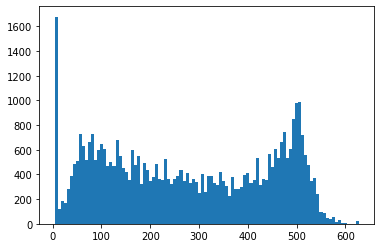

In [8]:
plt.hist(len_chars, 100);

In [9]:
np.sort(len_chars)[-25:]

array([598, 598, 598, 598, 598, 598, 624, 624, 624, 624, 624, 624, 624,
       624, 624, 624, 624, 624, 624, 624, 624, 628, 628, 628, 628])

In [10]:
np.argsort(len_chars)[-25:]

array([ 1004,  2155,  2583,  1944,  1215,  1697, 26462, 25374, 25160,
       26238, 26027, 26892, 27740, 27529, 27314, 28148, 27105, 26671,
       25806, 27946, 25589,  8596,  8192,  7966,  8391])

In [11]:
dataset.tags[8391]

'reps|"eleksmaker"|"laser"|"machine"|"cnc"|"pcb"|"exposer"|"modification"|"3d"|"printing"|"belt"|"profile"|"roller"|"tension"|"holder"|"end"|"stop"|"axis"|"adjust"|"play"|"friction"|"405"|"nm"|"microscope"|"diode"|"module"|"dot"|"pwm"|"infrared"|"ir"|"acrylic"|"tube"|"gantry"|"acceleration"|"speed"|"smd"|"footprint"|"trinamic"|"stepper"|"motor"|"driver"|"pololus"|"a4988"|"watterott"|"tmc2130"|"microstepping"|"phase"|"current"|"noise"|"coolstep"|"stallguard"|"stealthchop"|"spi"|"arduino"|"open"|"source"|"diy"|"resolution"|"interpolation"|"grbl"|"firmware"|"gcode"|"load"|"austin"|"powers"|"limit"|"switch"|"homing"|"bungard"'

In [12]:
dataset.category_id[8391]

28

In [13]:
np.sort(len_chars)[1]

4

In [14]:
dataset.tags[1]

'last week tonight trump presidency|"last week tonight donald trump"|"john oliver trump"|"donald trump"'

In [15]:
dataset.category_id[1]

24

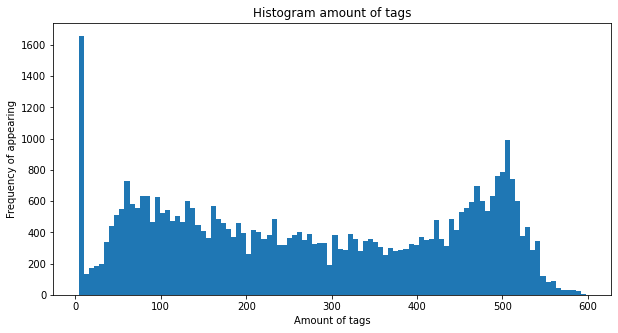

In [16]:
fig, ax = plt.subplots(figsize=(10,5))
ax.hist(len_chars[np.logical_and(len_chars > 1, len_chars < 600)], 100)
ax.set_title('Histogram amount of tags')
ax.set_xlabel('Amount of tags')
ax.set_ylabel('Frequency of appearing');

#### The next step we will see how tags are destributed by category_id

24    9964
10    6472
26    4146
23    3457
22    3210
25    2487
28    2401
1     2345
17    2174
27    1656
15     920
20     817
19     402
2      384
29      57
43      57
Name: category_id, dtype: int64


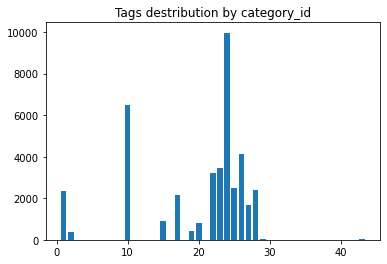

In [17]:
class_dist = dataset['category_id'].value_counts()
print(class_dist)
index = class_dist.index
values = class_dist.values
plt.title('Tags destribution by category_id')
plt.bar(index,values)
plt.show()

We can see that there is a little/no data for some categories therefore we are expect troubles with defining proper category for them

#### Tokenize reviews

In [18]:
nltk.word_tokenize(dataset.tags[100])

['Japan|',
 "''",
 'Japanese',
 "''",
 '|',
 "''",
 'yt',
 ':',
 'cc=on',
 "''",
 '|',
 "''",
 'idiot',
 "'s",
 "''",
 '|',
 "''",
 'guide',
 "''",
 '|',
 "''",
 'squat',
 "''",
 '|',
 "''",
 'toilets',
 "''",
 '|',
 "''",
 'washiki',
 "''",
 '|',
 "''",
 'toilet',
 "''",
 '|',
 "''",
 'japanese',
 'toilets',
 "''",
 '|',
 "''",
 'how',
 'to',
 "''",
 '|',
 "''",
 'use',
 "''",
 '|',
 "''",
 'bathroom',
 "''",
 '|',
 "''",
 'japanese',
 'bathroom',
 "''",
 '|',
 "''",
 'idiot',
 "'s",
 'guide',
 "''",
 '|',
 "''",
 '和式',
 "''",
 '|',
 "''",
 '使い方',
 "''",
 '|',
 "''",
 'rachel',
 "''",
 '|',
 "''",
 'jun',
 "''",
 '|',
 "''",
 'rachel',
 '&',
 'jun',
 "''",
 '|',
 "''",
 'rachel',
 'and',
 'jun',
 "''",
 '|',
 "''",
 '日本',
 "''",
 '|',
 "''",
 'ガイド',
 "''",
 '|',
 "''",
 '面白',
 "''",
 '|',
 "''",
 '海外',
 "''",
 '|',
 "''",
 'おもしろ',
 "''",
 '|',
 "''",
 'アメリカ',
 "''",
 '|',
 "''",
 '英会話',
 "''",
 '|',
 "''",
 '英語',
 "''",
 '|',
 "''",
 '外国',
 "''",
 '|',
 "''",
 'レイチェル',
 "''",
 '|',
 "

In [19]:
tokenized_reviews = [ nltk.word_tokenize(doc) for doc in dataset.tags ]
tokenized_reviews[0]

['SHANtell', 'martin']

In [20]:
tokenized_reviews = [ [word.lower() for word in doc] for doc in tokenized_reviews ] 

In [21]:
len_words = np.array( [len(tokenized_review) for tokenized_review in tokenized_reviews] )

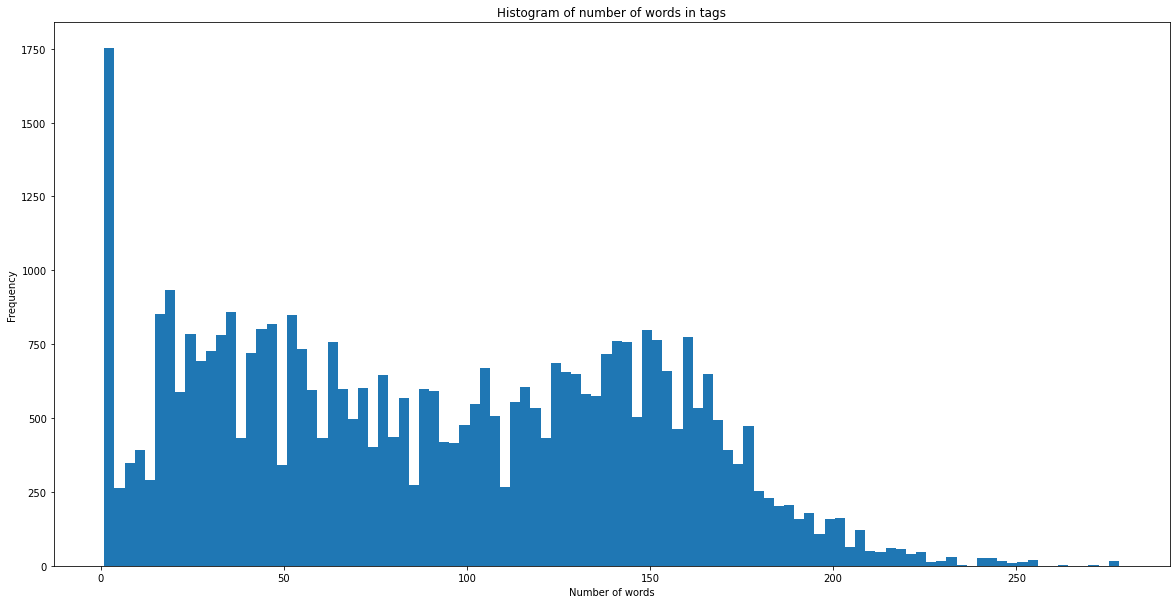

In [22]:
fig, ax = plt.subplots(figsize=(20,10)) 
ax.hist(len_words, 100)
ax.set_title('Histogram of number of words in tags')
ax.set_xlabel('Number of words')
ax.set_ylabel('Frequency');

In [23]:
np.sort(len_words[-10:])

array([  3,  16,  24,  54,  57,  98, 117, 117, 128, 143])

In [24]:
np.argsort(len_words[-100:])

array([96, 23, 31, 88, 13, 69, 10, 99, 41, 68, 18, 71,  5, 12, 72, 90, 59,
       87,  6, 77, 80, 15, 64, 60, 21, 52, 66, 86, 48, 34, 30, 95, 91, 75,
       20, 47, 61,  3, 22, 17, 37,  4, 55, 19,  8, 56, 16,  2,  7, 98, 32,
       82, 54, 25, 51, 67,  0, 58,  9, 35, 28, 94, 93, 39, 40, 26, 78, 92,
       27, 43, 33, 14, 79, 63, 65, 76, 89,  1, 97, 24, 11, 70, 42, 83, 73,
       57, 36, 45, 84, 62, 81, 46, 38, 50, 85, 53, 29, 74, 44, 49])

In [25]:
tokenized_reviews[49]

['iphone',
 'x|',
 "''",
 'animojis',
 "''",
 '|',
 "''",
 'facial',
 'recognition',
 "''",
 '|',
 "''",
 'elders',
 'react',
 'to',
 'iphone',
 'x',
 'facial',
 'recognition',
 'animojis',
 "''",
 '|',
 "''",
 'elders',
 'react',
 "''",
 '|',
 "''",
 'react',
 "''",
 '|',
 "''",
 'reaction',
 "''",
 '|',
 "''",
 'thefinebros',
 "''",
 '|',
 "''",
 'fine',
 'brothers',
 "''",
 '|',
 "''",
 'fine',
 'brothers',
 'entertainment',
 "''",
 '|',
 "''",
 'finebros',
 "''",
 '|',
 "''",
 'fine',
 'bros',
 "''",
 '|',
 "''",
 'fbe',
 "''",
 '|',
 "''",
 'watch',
 "''",
 '|',
 "''",
 'review',
 "''",
 '|',
 "''",
 'for',
 'the',
 'first',
 'time',
 "''",
 '|',
 "''",
 'reviews',
 "''",
 '|',
 "''",
 'responds',
 "''",
 '|',
 "''",
 'respond',
 "''",
 '|',
 "''",
 'youtubers',
 'react',
 "''",
 '|',
 "''",
 'teens',
 'react',
 "''",
 '|',
 "''",
 'kids',
 'react',
 "''",
 '|',
 "''",
 'adults',
 'react',
 "''",
 '|',
 "''",
 'parents',
 'react',
 "''",
 '|',
 "''",
 'teenagers',
 'react',
 "''",

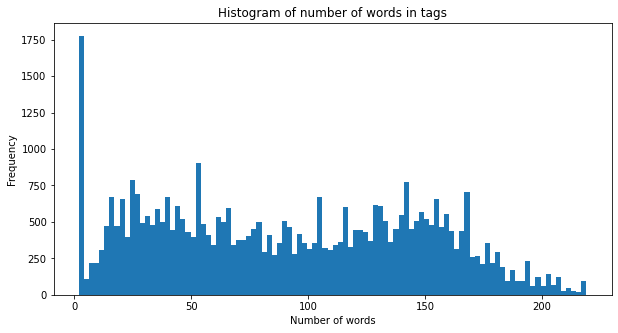

In [26]:
fig, ax = plt.subplots(figsize=(10,5))
ax.hist( len_words[np.logical_and(len_words > 1, len_words < 220)], 100 )
ax.set_title('Histogram of number of words in tags')
ax.set_xlabel('Number of words')
ax.set_ylabel('Frequency');

In [27]:
all_words = [word for doc in tokenized_reviews for word in doc]

In [28]:
all_words_counter = Counter(all_words)

In [29]:
all_words_counter.most_common(20)

[("''", 1532589),
 ('|', 728376),
 ('the', 19534),
 ('to', 9824),
 ('video', 8072),
 ('makeup', 7811),
 ('funny', 7304),
 ('how', 7141),
 ('new', 7084),
 ('of', 6622),
 ('2018', 6368),
 ('and', 6331),
 ('music', 6305),
 ('a', 5764),
 ('news', 5366),
 ('show', 5239),
 ('food', 4789),
 ('comedy', 4676),
 ('trailer', 4423),
 ('movie', 4374)]

Text(0.5, 1.0, 'The 25 most common tags')

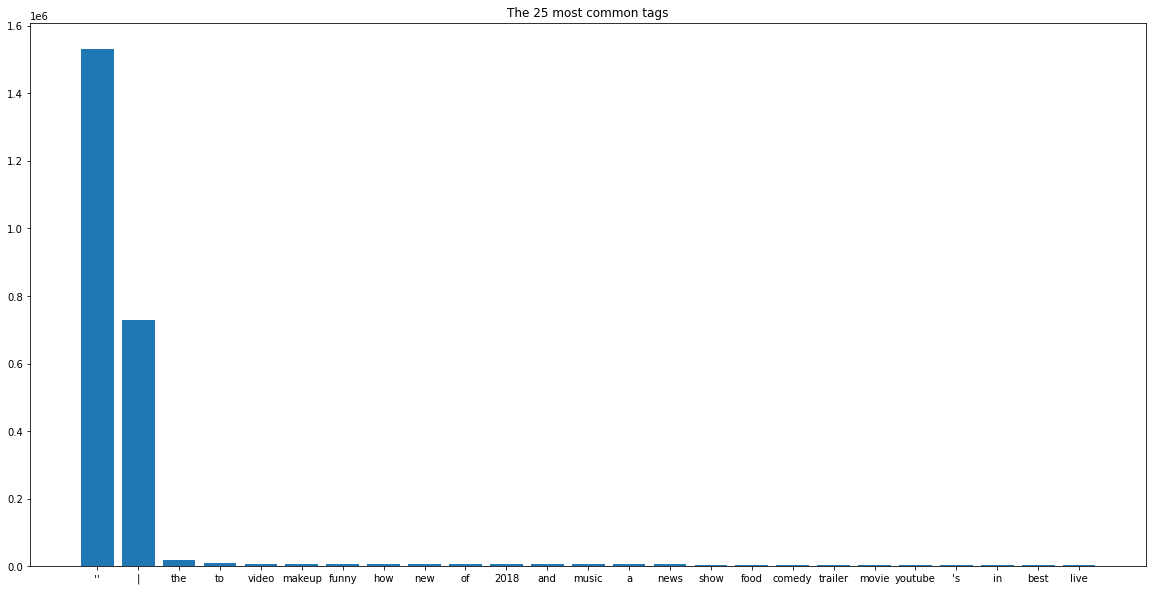

In [30]:
x, y = zip( *all_words_counter.most_common(25) )
fig, ax = plt.subplots(figsize = (20, 10))
ax.bar(x, y)
ax.set_title('The 25 most common tags')

#### Keeping words

In [31]:
filtered_words = [word for word in all_words if word.isalpha()]
filtered_words_counter = Counter (filtered_words)

Text(0.5, 1.0, 'The 25 most common words')

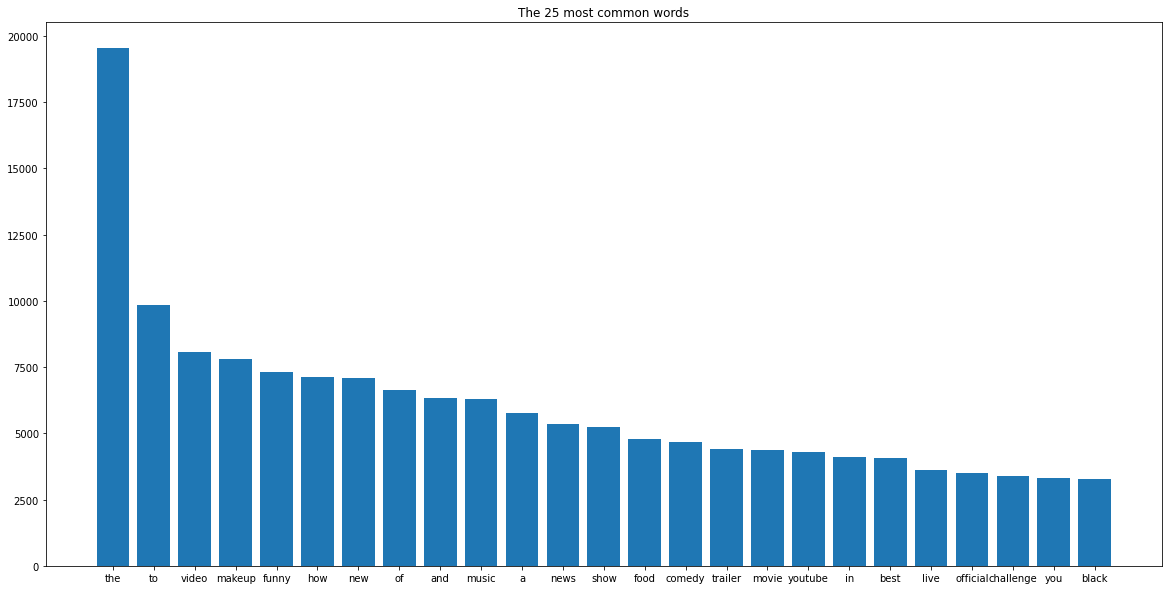

In [32]:
x, y = zip( *filtered_words_counter.most_common(25) )
fig, ax = plt.subplots(figsize = (20, 10))
ax.bar(x, y)
ax.set_title('The 25 most common words')

#### Discarding stopwords

In [33]:
stopwords = set(nltk.corpus.stopwords.words('english'))
stopwords

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [34]:
filtered_words_stop = [word for word in filtered_words if word not in stopwords]
filtered_words_stop_counter = Counter(filtered_words_stop)

Text(0.5, 1.0, 'The 25 most common words')

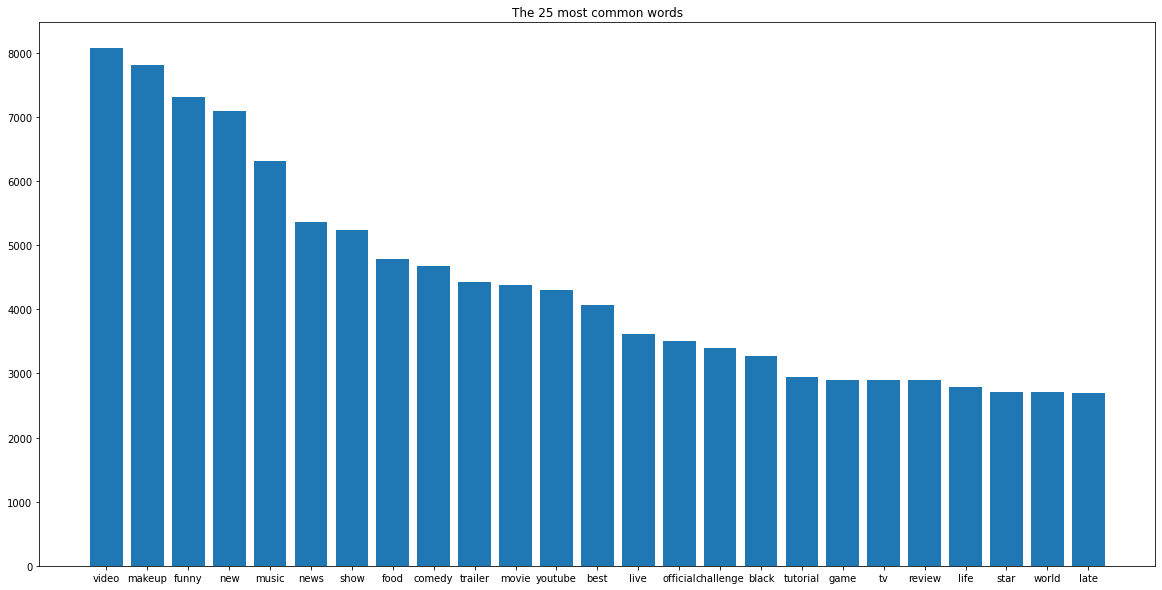

In [35]:
x, y = zip( *filtered_words_stop_counter.most_common(25) )
fig, ax = plt.subplots(figsize = (20, 10))
ax.bar(x, y)
ax.set_title('The 25 most common words')

#### Why is "makeup" so frequent?

In [36]:
def concordance (words, target_word, contex_width = 3, contex_num = 20):
    concordance_gen = (filtered_words[ i-contex_width: i+contex_width ] for i, word in enumerate(filtered_words) if word == target_word)
    return list(islice(concordance_gen, contex_num))

In [37]:
concordance(all_words, 'makeup')

[['facts', 'iphone', 'iphonex', 'makeup', 'iphonex', 'test'],
 ['iphone', 'iphone', 'vs', 'makeup', 'face', 'id'],
 ['hack', 'iphone', 'x', 'makeup', 'tutorial', 'makup'],
 ['tutorial', 'makup', 'tutorial', 'makeup', 'promise', 'phan'],
 ['online', 'dollar', 'store', 'makeup', 'for', 'a'],
 ['online', 'dollar', 'store', 'makeup', 'dollar', 'store'],
 ['makeup', 'dollar', 'store', 'makeup', 'daiso', 'shopmissa'],
 ['makeup', 'daiso', 'shopmissa', 'makeup', 'shopmissa', 'haul'],
 ['haul', 'dollar', 'store', 'makeup', 'haul', 'dollar'],
 ['face', 'powder', 'lipstick', 'makeup', 'safiya', 'makeup'],
 ['lipstick', 'makeup', 'safiya', 'makeup', 'safiya', 'dollar'],
 ['tanned', 'skin', 'tan', 'makeup', 'cheese', 'goat'],
 ['cosmetics', 'classic', 'glam', 'makeup', 'tutorial', 'holiday'],
 ['glam', 'red', 'lip', 'makeup', 'tutorial', 'how'],
 ['red', 'lip', 'bulletproof', 'makeup', 'long', 'lasting'],
 ['makeup', 'long', 'lasting', 'makeup', 'the', 'late'],
 ['ideas', 'how', 'to', 'makeup', 's

#### Trigrams

In [38]:
trigrams = nltk.trigrams(filtered_words)
trigrams = (( (w1, w2),w3) for w1, w2, w3 in trigrams ) 
cond_pd = nltk.ConditionalProbDist(nltk.ConditionalFreqDist(trigrams), nltk.MLEProbDist)

In [39]:
def generate_text(cond_pd, start, length):
    word1, word2 = start
    text = [word1]
    for i in range(length):
        text.append(word2)
        try:
            word = cond_pd[ (word1, word2) ].generate()
        except:
            print('The pair {} is not among the conditions of our trigram model, stopping'.format((word1, word2)))
            break
        word1 = word2
        word2 = word
    return text

In [40]:
cond_pd['makeup', 'tutorial'].freqdist()

FreqDist({'beauty': 116, 'makeup': 110, 'tutorial': 107, 'review': 102, 'i': 69, 'james': 63, 'how': 54, 'smokey': 46, 'following': 35, 'drugstore': 30, ...})

In [41]:
generate_text(cond_pd, ('makeup', 'tutorial'), 8)

['makeup',
 'tutorial',
 'clearance',
 'makeup',
 'challenge',
 'full',
 'face',
 'of',
 'wish']

### Conducting Deep Machine Learning Experiments

In [42]:
from collections import Counter
import numpy as np
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf

In [43]:
num_of_features = 5000
num_of_examples = 10000
corpus = dataset.tags[:num_of_examples]
corpus = [doc.lower() for doc in corpus]
categories = dataset.category_id[:num_of_examples]

In [44]:
class TransformTokenizer:
    def __init__(self, transform):
        self.transform = transform
        
    def __call__(self, doc):
        return [self.transform(word) for word in nltk.word_tokenize(doc)]

In [45]:
stemmer = nltk.stem.PorterStemmer()
tfidf_vectorizer_stemming = TfidfVectorizer(tokenizer=TransformTokenizer(stemmer.stem), max_df=0.95, min_df=2, max_features=num_of_features, stop_words='english')
bows = tfidf_vectorizer_stemming.fit_transform(corpus)

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
 

In [46]:
X_train, X_test, y_train, y_test = train_test_split(bows, categories, test_size=0.1, shuffle=False)

In [47]:
y_train

0       22
1       24
2       23
3       24
4       24
        ..
8995    24
8996    25
8997    28
8998    27
8999    28
Name: category_id, Length: 9000, dtype: int64

In [48]:
np.unique(y_train)

array([ 1,  2, 10, 15, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 43])

In [49]:
num_of_classes = np.unique(y_train).shape[0]
num_of_classes

16

In [50]:
print(y_train[:10])
y_train = tf.keras.utils.to_categorical(y_train)
print(y_train[:10])
y_test = tf.keras.utils.to_categorical(y_test)

0    22
1    24
2    23
3    24
4    24
5    28
6    24
7    28
8     1
9    25
Name: category_id, dtype: int64
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [51]:
X_train

<9000x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 168398 stored elements in Compressed Sparse Row format>

In [52]:
X_train = X_train.toarray()
X_test = X_test.toarray()

In [53]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(num_of_classes, activation=tf.keras.activations.softmax)
])

In [54]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [55]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [56]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [57]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10


ValueError: in user code:

    /home/nick/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /home/nick/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/nick/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/nick/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/nick/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/nick/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /home/nick/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:748 train_step
        loss = self.compiled_loss(
    /home/nick/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /home/nick/.local/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    /home/nick/.local/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /home/nick/.local/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/nick/.local/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:1535 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    /home/nick/.local/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/nick/.local/lib/python3.8/site-packages/tensorflow/python/keras/backend.py:4687 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /home/nick/.local/lib/python3.8/site-packages/tensorflow/python/framework/tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 44) and (None, 16) are incompatible


In [58]:
model.evaluate(X_test, y_test)

ValueError: in user code:

    /home/nick/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1224 test_function  *
        return step_function(self, iterator)
    /home/nick/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1215 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/nick/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/nick/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/nick/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/nick/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1208 run_step  **
        outputs = model.test_step(data)
    /home/nick/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1176 test_step
        self.compiled_loss(
    /home/nick/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /home/nick/.local/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    /home/nick/.local/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /home/nick/.local/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/nick/.local/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:1535 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    /home/nick/.local/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/nick/.local/lib/python3.8/site-packages/tensorflow/python/keras/backend.py:4687 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /home/nick/.local/lib/python3.8/site-packages/tensorflow/python/framework/tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 44) and (None, 16) are incompatible


#### Word embeddings

#### Words to numbers

In [59]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_of_features)
tokenizer.fit_on_texts(corpus)

In [60]:
sequences = tokenizer.texts_to_sequences(corpus)

In [61]:
corpus[87]

'little|"big"|"town"|"with"|"jimmy"|"webb"|"wichita"|"lineman"|"(live"|"from"|"the"|"cma"|"awards)"|"country"|"music"|"association"|"classic"'

In [62]:
print(sequences[87])

[776, 117, 3245, 29, 417, 18, 314, 1, 129, 404, 11]


#### Padding

In [63]:
[len(sequence) for sequence in sequences[:10]]

[2, 14, 37, 58, 13, 15, 69, 36, 63, 24]

In [64]:
sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=1000)

In [65]:
[len(sequence) for sequence in sequences[:10]]

[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]

In [66]:
print(sequences[68])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

#### Training

In [67]:
X_train, X_test, y_train, y_test = train_test_split(sequences, categories, test_size=0.1, shuffle=False)

In [68]:
print(y_train[:10])
y_train = tf.keras.utils.to_categorical(y_train)
print(y_train[:10])
y_test = tf.keras.utils.to_categorical(y_test)

0    22
1    24
2    23
3    24
4    24
5    28
6    24
7    28
8     1
9    25
Name: category_id, dtype: int64
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [73]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_of_features, 300),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(num_of_classes, activation=tf.keras.activations.softmax)
])

In [74]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         1500000   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 300)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_5 (Dense)              (None, 16)                1616      
Total params: 1,531,716
Trainable params: 1,531,716
Non-trainable params: 0
_________________________________________________________________


In [75]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [76]:
model.fit(X_train, y_train, epochs=100, validation_split=0.1)

Epoch 1/100


ValueError: in user code:

    /home/nick/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /home/nick/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/nick/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/nick/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/nick/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/nick/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /home/nick/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:748 train_step
        loss = self.compiled_loss(
    /home/nick/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /home/nick/.local/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    /home/nick/.local/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /home/nick/.local/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/nick/.local/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:1535 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    /home/nick/.local/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/nick/.local/lib/python3.8/site-packages/tensorflow/python/keras/backend.py:4687 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /home/nick/.local/lib/python3.8/site-packages/tensorflow/python/framework/tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 44) and (None, 16) are incompatible


In [ ]:
model.evaluate(X_test, y_test)